# Generating Synthetic Data

## Importing Packages

In [79]:
import numpy as np
import pandas as pd

# packages needed for creating x 
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt
import seaborn as sns

def p(x):
    return pd.DataFrame(x)

## Generating Z and Y 

In [26]:

E=[0.2, 2, 3, 5] # environmental factors
S=[1,2,3,4]


def generate_z_and_y(E,S):
    beta_z1 = np.random.normal(0,1)
    beta_z2 = np.random.normal(0,1)
    beta_z3 = np.random.normal(0,1)
    env_y = []
    env_z = []

    for i in range(len(E)):
        # Draw beta
        beta1 = np.random.normal(0,1)
        beta2 = np.random.normal(0,1)
        
        # Create Z1
        Z1=np.random.normal(beta1*E[i], 1, 1000)
        #Z1=np.vstack((Z1, np.array([S[i]]*1000))).reshape(-1,1000).T
        
        # Create Z2
        Z2=np.random.normal(2*beta2*E[i], 2, 1000)
        #Z2=np.vstack((Z2, np.array([S[i]]*1000))).reshape(-1,1000).T

        # Create Y
        Y=np.zeros(1000)

        # Create Z3
        Z3=np.zeros(1000)
        for i in range(len(Z1)):
            Y[i] = np.random.normal(beta_z1*Z1[i]+beta_z2*Z2[i], 1)


            Z3[i]=np.random.normal(3*beta_z3*Y[i], 1)

        env_y.append(pd.DataFrame(Y))
        env_z.append(pd.DataFrame(np.vstack((Z1[:], Z2[:], Z3[:])).T))


    Y=pd.concat([env_y[0], env_y[1], env_y[2], env_y[3]],axis=1)
    Y.columns = list(np.arange(1,5))
    Z=pd.concat([env_z[0], env_z[1], env_z[2], env_z[3]],axis=1)
    Zs=np.zeros((1000, 4, 4))
    # categories=[0,1,2,3]
    for i in range(len(E)):#categories:
        Zs[:,:3,i]=env_z[i]
        Zs[:,3,i]=i+1

    return Zs, Y

In [27]:
Zs, Y = generate_z_and_y(E,S)

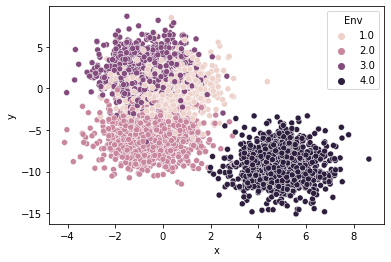

In [80]:
def plot_latent_2d(Z1, Z2, Env):
    plot_df = pd.concat([Z1, Z2, Env],axis=1)
    plot_df.columns=['x', 'y', 'Env']
    sns.scatterplot(data=plot_df, x='x', y='y', hue='Env')
    
plot_latent_2d(p(Zs[:,0,:].reshape(-1,1)), p(Zs[:,1,:].reshape(-1,1)), p(Zs[:,3,:].reshape(-1,1)))

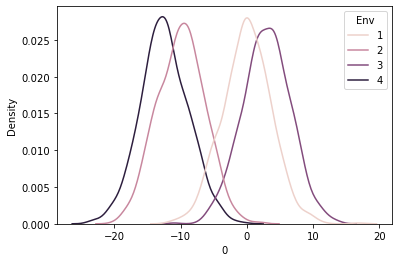

In [81]:
def plot_y_dist(Y):
    hue=pd.DataFrame(Y.stack()).index.get_level_values(1)
    xindex=pd.DataFrame(Y.stack()).index.get_level_values(0)
    stacked = pd.DataFrame(Y.stack())
    stacked['x']=xindex
    stacked['Env']=hue
    sns.kdeplot(data=stacked, x=0, hue='Env')
    plt.show()

plot_y_dist(Y)

In [51]:

#Hyperparameters
num_classes = 10
num_l1 = 6
num_features = 3

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # hidden layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # output layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        return x


net = Net(num_features, num_l1, num_classes)

In [85]:
print(net(torch.from_numpy(Zs[:,:3,1].astype("float32"))).size())

X = net(torch.from_numpy(Zs[:,:3,1].astype("float32")))
Xs = [net(torch.from_numpy(Zs[:,:3,i[0]].astype("float32"))) for i in enumerate(E)]

torch.Size([1000, 10])


# Reformatting Data to Pytorch Dataset

In [87]:
# Code to export the data to csvs
# Will remove after next github push

# # turn all data into Dataframes 
# y_df = pd.DataFrame(Y, columns = ['Y'])
# x_df = pd.DataFrame(X)
# # zs_df = pd.DataFrame(Zs, columns = ["Z1", "Z2", "Z3", "Environments"])
# # save data to file 
# y_df.to_csv('y.csv') 
# # zs_df.to_csv('zs.csv') 
# x_df.to_csv('x.csv') 

In [88]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomSyntheticDataset(Dataset):
    def __init__(self,X,Zs,Y):
        self.X = X
        self.Zs = Zs
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        # get label from Y 
        label = self.Y[idx,:]
        # get Zs for each env't
        selected_zs = self.Zs[idx,:,:] 
        # get X 
        selected_x = self.X[idx,:]
        return selected_x, selected_zs, label

    def return_training(self):
        return X
    
    def return_testing(self):
        return Y

In [89]:
dataset_instance = CustomSyntheticDataset(X,Zs,Y)

# Modifying VAE Exercise Data Import Code

In [90]:
#dset_train[:900,:]

In [91]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")


from torch.distributions import Bernoulli

# data imports 
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

#classes = [*range(1, len(E), 1)] # environments
#def stratified_sampler(labels):
#    """Sampler that only picks datapoints corresponding to the specified classes"""
#    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
#    indices = torch.from_numpy(indices)
#    return SubsetRandomSampler(indices)

dset_train = dataset_instance.return_training()
dset_test = dataset_instance.return_testing()

batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train[:910,:], batch_size=batch_size)
test_loader  = DataLoader(dset_train[910:,:], batch_size=eval_batch_size)

## Implement Gaussian Distribution

In [92]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.distributions import Normal

class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.sample_epsilon() * self.sigma + self.mu 
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        # create a normal distribution to sample from 
        m = Normal(self.mu, self.sigma)
        # get probability of choosing z from that distribution
        return m.log_prob(z)


# Implement VAE

In [93]:
X[0].shape

torch.Size([10])

In [94]:
import pdb

class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # q_phi(z|x) = N(z | mu(x), sigma(x)),
        # mu(x),
        # log(sigma(x)) = h_phi(x)`
        
        # Step 1:
        # Define input dimensions -> self.input_shape
        # Step 2:
        # Define the rest of the encoding architecture
        self.encoder = nn.Sequential(
             nn.Linear(in_features=self.observation_features, out_features=10),
             nn.ReLU(),
            # nn.Linear(in_features=1024, out_features=512),
            # nn.ReLU(),
            # nn.Linear(in_features=512, out_features=256),
            # nn.ReLU(),
            # nn.Linear(in_features=256, out_features=128),
            # nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=10, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_theta(x | z) = prod_i B(x_i | g_theta(x))`
        
        # Step 3:
        # Decode from latent space back to X
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=10),
            nn.ReLU(),
            # nn.Linear(in_features=128, out_features=256),
            # nn.ReLU(),
            # nn.Linear(in_features=256, out_features=512),
            # nn.ReLU(),
            # nn.Linear(in_features=512, out_features=1024),
            # nn.ReLU(),
            nn.Linear(in_features=10, out_features=self.observation_features)
            # 2*self.observation_features
            # Index which of the outputs are mu and which are sigma
        )
        
        # Step 4:
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | mu(x), sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | mu(x), sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        #pdb.set_trace()
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        #pdb.set_trace()
        #return Bernoulli(logits=px_logits, validate_args=False)
        return Normal(px_logits, 0.1)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z) # Just assume a standard prior with mean 0 and var 1
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        #print(qz)
        
        # define the observation model p(x|z) = B(x | g(z))
        # Decode
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 3
vae = VariationalAutoencoder(X[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


## Implement Variational Inference (ie Training)

In [95]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        self.a=0
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        # Get parameters of the prior and posterior and px and z's
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        # Whats the probability of getting x and z given the estimated distributions
        log_px = reduce(px.log_prob(x))
        #pdb.set_trace()
        self.a+=1
        #print(self.a)
        #pdb.set_trace()
        #print(qz.mu)
        #print(qz.mu.shape)
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^beta = E_q [ log p(x|z) ] - beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo =  log_px - self.beta*kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

## Training

In [105]:
## Initialization 
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 3
vae = VariationalAutoencoder(X[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

In [106]:
## Training Loop 

num_epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    #for x, y in train_loader:
    for x in train_loader:
    
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        #x, y = next(iter(test_loader))
        x= next(iter(test_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBOwhy 
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    # make_vae_plots(vae, x, y, outputs, training_data, validation_data)

>> Using device: cuda:0


In [98]:
outputs['z']
px = vae.sample_from_prior(batch_size=x.size(0))['px']
x_samples = px.sample()

In [112]:
p(Tensor.cpu(outputs['z']).numpy())

,0,1,2
0,-0.311981,-1.457065,0.476226
1,0.198606,-1.119365,0.413435
2,0.601324,-0.244939,1.042825
3,0.363357,-1.105180,0.356886
4,-0.119289,0.347627,-0.357344
...,...,...,...
85,0.421829,-0.375723,1.612987
86,-0.636589,0.100499,-0.835634
87,-1.395690,-0.218454,-1.671617
88,-1.023442,-0.398093,0.149086


In [100]:
X.mean(axis=0)

tensor([-0.1058,  0.0027, -0.0628,  0.0009, -0.0357,  0.1103,  0.0616,  0.0778,
         0.0134,  0.1164], grad_fn=<MeanBackward1>)

In [101]:
X[910:,:].mean(axis=0)

tensor([-0.1077,  0.0038, -0.0623,  0.0037, -0.0382,  0.1131,  0.0659,  0.0777,
         0.0157,  0.1195], grad_fn=<MeanBackward1>)

In [102]:
x_samples.mean(axis=0)

tensor([-0.1242, -0.0036, -0.0886, -0.0119, -0.0424,  0.0998,  0.0524,  0.0552,
         0.0064,  0.0964], device='cuda:0')

In [103]:
VariationalAutoencoder(X)

TypeError: __init__() missing 1 required positional argument: 'latent_features'